# Simulation of MEGA-edited dynamic fitting

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from fsl_mrs.utils import mrs_io
from fsl_mrs.utils import synthetic as syn
from fsl_mrs.utils.fitting import fit_FSLModel
from fsl_mrs.core import MRS
from fsl_mrs import dynamic as dyn
import pandas as pd



## Load the basis sets and some example data

In [3]:
basis_on = mrs_io.read_basis('basis_sets/uzay_svs_mpress_68_res_60_on/')
basis_off = mrs_io.read_basis('basis_sets/uzay_svs_mpress_68_res_60_off/')
basis_diff = mrs_io.read_basis('basis_sets/uzay_svs_mpress_68_res_60_diff/')

The above contain basis spectra for GABA-targeted MEGE-edited PRESS sequences, both the on-resonance (ON) and off-resonance (OFF) conditions and their difference (DIFF)

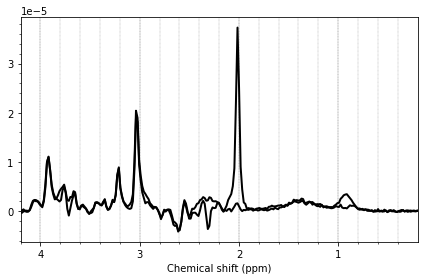

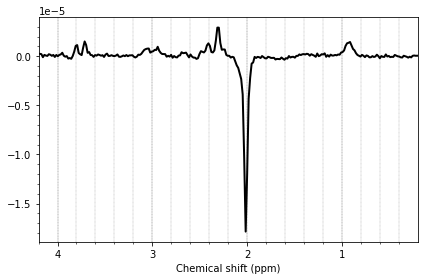

In [4]:
example_sep = mrs_io.read_FID('example_data/separate.nii.gz')
example_diff = mrs_io.read_FID('example_data/diff.nii.gz')

example_sep.mrs()[0].plot()
example_sep.mrs()[1].plot()
plt.show()

example_diff.mrs().plot()
plt.show()


View some synthetic spectra

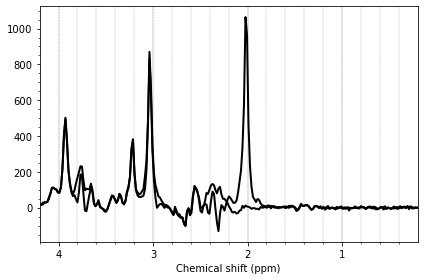

In [5]:
def synthesize(basis, noise, lw, conc):
    synthesised = syn.synthetic_from_basis.syntheticFromBasisFile(
        basis,
        broadening=lw,
        noisecovariance=[[noise]],
        concentrations=conc)
    mrs = synthesised[1]
    mrs.FID = synthesised[0]
    concs_out = synthesised[2]
    return mrs, concs_out

def synthesize_diff(mrs_on, mrs_off):
    fid_diff = mrs_on.FID - mrs_off.FID * (mrs_on.scaling['basis']/mrs_off.scaling['basis'])
    mrs_diff = MRS(FID=fid_diff,cf=mrs_on.centralFrequency, bw=mrs_on.bandwidth, basis=basis_diff)
    mrs_diff.keep = ['NAA', 'NAAG', 'GABA', 'GSH','Glu', 'Gln']
    mrs_diff.processForFitting()
    return mrs_diff

noise = 20

synthesize(basis_on, noise, (np.pi*3, 0), {'GABA': 3.5})[0].plot()
synthesize(basis_off, noise, (np.pi*3, 0), {'GABA': 3.5})[0].plot()

## Match noise and linewidth

1. Linewidth: fit and extract raw lorentzian peak shape parameter.

[7.94465021]


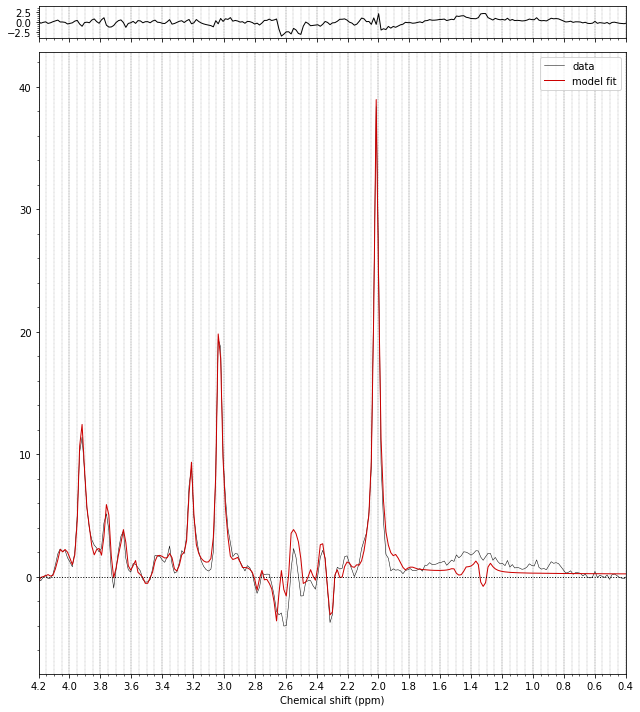

In [6]:
from fsl_mrs.utils.plotting import plot_fit
real_off = example_sep.mrs(basis=basis_off)[0]
real_off.processForFitting()
fitargs_real = {'model':'lorentzian', 'baseline_order':0}
res_real_off = fit_FSLModel(real_off, **fitargs_real)
fig = plot_fit(real_off, res_real_off.pred)

print(res_real_off.getLineShapeParams(units='raw')[0])

2. SNR: Normalise to unit noise SD. Compare with synthetic spectra

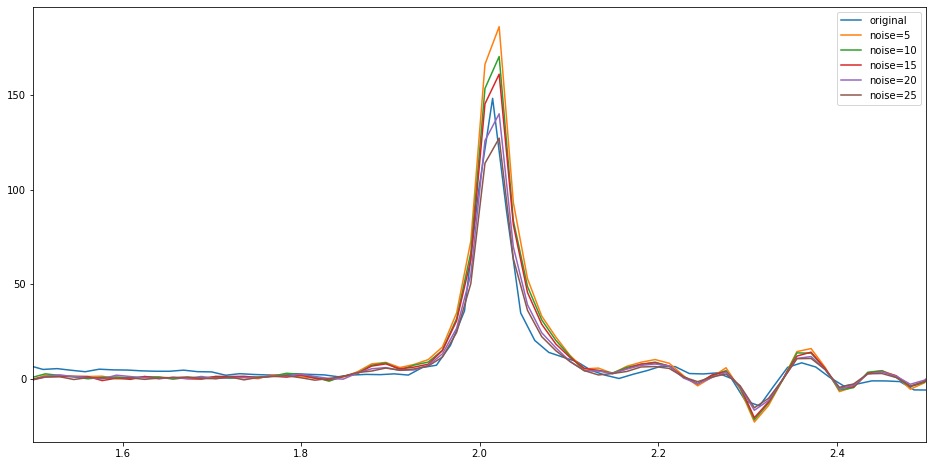

In [7]:
def plot_unit_baseline(ax, mrs, label):
    spec = mrs.get_spec()
    sd_baseline = mrs.get_spec(ppmlim=(0, -5.0)).std()
    spec_scaled = spec / sd_baseline
    ax.plot(mrs.getAxes(), spec_scaled.real, label=label)

fig = plt.figure(figsize=(16,8))
plot_unit_baseline(fig.gca(), real_off, 'original')

for noise in [5, 10, 15, 20, 25]:
    plot_unit_baseline(
        fig.gca(),
        synthesize(basis_off, noise, (7.94465021, 0), {'GABA': 3.5})[0],
        f'noise={noise}')

plt.xlim([5, 4.65-10])
plt.xlim([1.5, 2.5])
plt.legend()
plt.show()


### Explore SNR / linewidth space

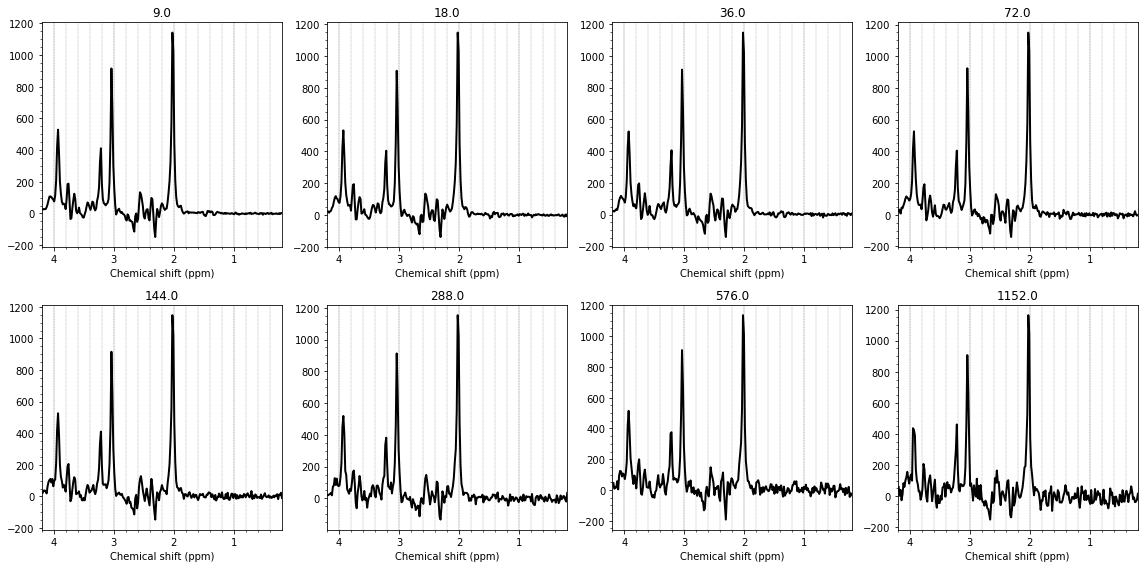

In [8]:
noise_vec = [np.round(9*(np.sqrt(4)**x)) for x in range(8)]
fig, axes = plt.subplots(2, 4, figsize=(16,8))
for noise, ax in zip(noise_vec, axes.ravel()):
    plt.axes(ax)
    ax.set_title(str(noise))
    synthesize(basis_off, noise, (7.94465021, 0), {'GABA': 3.5})[0].plot()
    

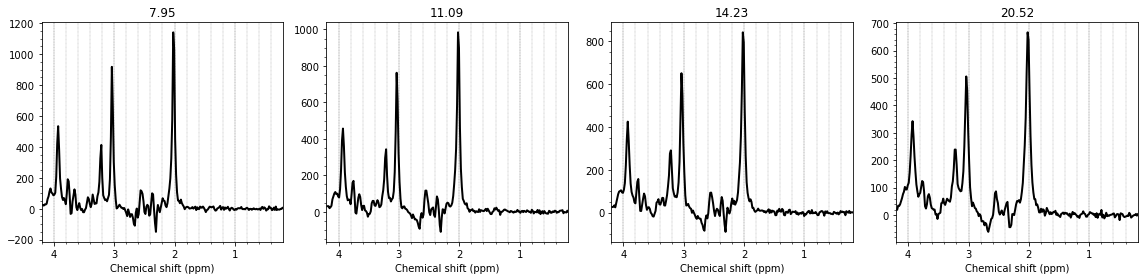

In [15]:
fig, axes = plt.subplots(1, 4, figsize=(16,4))
lw_vec = [7.95, 7.95+np.pi,  7.95+2*np.pi,  7.95+4*np.pi]
for lw, ax in zip(lw_vec, axes.ravel()):
    plt.axes(ax)
    ax.set_title(f'{lw:0.2f}')
    synthesize(basis_off, 36, (lw, 0), {'GABA': 3.5})[0].plot()

## MC fitting loop
Create a loop that can generate and fit a synthetic dataset

In [59]:

def run_iteration(lw, noise):

    # Create an instance of data:
    # 1. The ON condition
    syn_mrs_on, on_concs = synthesize(basis_on, noise, lw, {'GABA': 3.5})
    # 2. The OFF condition
    syn_mrs_off, _ = synthesize(basis_off, noise, lw, on_concs)
    # 3. The OFF condition, but double the acqusition time (sqrt(2) less noise)
    syn_mrs_off_equiv, _ = synthesize(basis_off, noise / 1.4, lw, on_concs)
    # 4. The difference spectrum
    syn_mrs_diff = synthesize_diff(syn_mrs_on, syn_mrs_off)


    # Run the fitting
    # Fitting options
    mg = [0,] * len(on_concs)
    fitargs = {'model':'lorentzian', 'baseline_order':0, 'metab_groups': mg}
    fitargs_diff = {'model':'lorentzian', 'baseline_order':0, 'metab_groups': [0,] * 6}

    # Run individual fits
    res_on = fit_FSLModel(syn_mrs_on, **fitargs,)
    res_off = fit_FSLModel(syn_mrs_off, **fitargs)
    res_off_equiv = fit_FSLModel(syn_mrs_off_equiv, **fitargs)
    res_diff = fit_FSLModel(syn_mrs_diff, **fitargs_diff)

    on_off_to_diff_scaling = \
        (syn_mrs_diff.scaling['basis'] / syn_mrs_on.scaling['basis'])\
        * (syn_mrs_on.scaling['FID'] / syn_mrs_diff.scaling['FID'])

    # Extract individual concnetration parameters
    df_res = pd.concat(
    (res_off.getConc(function=None),
     res_off_equiv.getConc(function=None),
     res_on.getConc(function=None),
     res_diff.getConc(function=None) * on_off_to_diff_scaling
     ))
    df_res.set_index(np.array(['Off', 'Off Matched' ,'On', 'Diff']), inplace=True)

    # Run dynamic fitting
    mrs_list = [syn_mrs_off, syn_mrs_on]
    tvar = [0, 1]
    dyn_obj = dyn.dynMRS(mrs_list, tvar, 'editconfig.py',rescale=False, **fitargs)
    init = dyn_obj.initialise(indiv_init=None)
    dyn_res = dyn_obj.fit(init=init)
    
    # Extract dynamic concentration parameters
    df_dyn = dyn_res.dataframe_free.filter(like='conc', axis=1)
    df_dyn.columns = df_res.columns[:-1]
    df_dyn.set_index(np.array(['Dyn']), inplace=True)


    return pd.concat((df_res, df_dyn)), {'dyn': dyn_res, 'diff':(syn_mrs_diff, res_diff),'off':(syn_mrs_off_equiv, res_off_equiv)}

example_df, res_objs = run_iteration((20, 0),  36)

example_df

Ala       Asc       Asp        Cr      GABA       GPC  \
Off          0.588444  1.143814  2.471219  4.385402  3.211030  0.792853   
Off Matched  0.729965  1.296948  2.284054  4.766649  3.574651  0.508657   
On           0.340004  0.866060  2.350938  4.728339  3.577182  0.812927   
Diff              NaN       NaN       NaN       NaN  3.341536       NaN   
Dyn          0.465658  1.006126  2.499330  4.640693  3.480860  0.812710   

                  GSH       Glc       Gln        Glu       Ins       Lac  \
Off          1.269578  1.138737  3.602810  11.567104  7.797594  0.822279   
Off Matched  1.220872  0.520627  2.845806  12.544694  7.540477  0.825350   
On           1.202216  1.190753  3.719669  12.311392  7.562162  0.770821   
Diff         1.438805       NaN  3.594242  12.095267       NaN       NaN   
Dyn          1.231056  1.210048  3.754129  12.221759  7.680492  0.776402   

                   NAA      NAAG       PCh       PCr        PE    Scyllo  \
Off          13.712072  1.345485  0.809668  5.294810  2.338978  0.267574   
Off Matched  13.799583  1.156830  1.054014  4.951515  0.983102  0.309431   
On           14.282135  0.879525  0.752863  4.861783  1.840459  0.291563   
Diff         13.716296  1.366057       NaN       NaN       NaN       NaN   
Dyn          13.803955  1.260831  0.781696  5.017445  2.262607  0.282145   

                  Tau    Cr+PCr  
Off          1.342089  9.680212  
Off Matched  1.243291  9.718165  
On           1.464771  9.590122  
Diff              NaN       NaN  
Dyn          1.429174       NaN

# Prototype MC loop

In [21]:
reps = 5
df_container = []
for idx in range(reps):
    df_container.append(run_iteration((7.95,0), 36)[0])
df = pd.concat(df_container, axis=0, keys=np.arange(0,len(df_container)))
df.to_csv('test_mc_df.csv')

In [23]:
pd.read_csv('test_mc_df.csv', index_col=[0,1])

Ala       Asc       Asp        Cr      GABA       GPC  \
0 Off          0.549124  1.267212  2.100503  4.985012  3.633501  0.665750   
  Off Matched  0.593413  1.082947  2.295245  4.896159  3.394609  0.672981   
  On           0.510131  0.882259  2.316948  5.038181  3.459945  0.639065   
  Diff              NaN       NaN       NaN       NaN  3.507966       NaN   
  Dyn          0.538393  1.086809  2.223423  5.011027  3.538938  0.659526   
1 Off          0.754764  1.336370  2.385891  5.081700  3.396630  0.642841   
  Off Matched  0.590770  1.320643  2.463955  4.868767  3.505593  0.709348   
  On           0.558658  1.232287  2.395976  4.850515  3.389209  0.733358   
  Diff              NaN       NaN       NaN       NaN  3.449054       NaN   
  Dyn          0.671401  1.282084  2.392083  5.000542  3.346736  0.698111   
2 Off          0.538354  0.811871  2.514615  4.931819  3.396386  0.839217   
  Off Matched  0.570400  1.056100  2.551750  4.882686  3.526666  0.795958   
  On           0.733759  0.861112  2.192808  4.839888  3.433767  0.854630   
  Diff              NaN       NaN       NaN       NaN  3.445856       NaN   
  Dyn          0.617868  0.841225  2.340992  4.848563  3.412869  0.837662   
3 Off          0.593359  1.337848  2.363522  4.730337  3.730755  0.821295   
  Off Matched  0.593153  1.103615  2.221053  4.835263  3.385668  0.703833   
  On           0.709655  1.128670  2.275761  4.717828  3.680053  0.796017   
  Diff              NaN       NaN       NaN       NaN  3.619449       NaN   
  Dyn          0.648018  1.210348  2.315707  4.729428  3.610375  0.806803   
4 Off          0.541598  1.509706  2.209227  4.828180  3.386659  0.870919   
  Off Matched  0.541976  1.064207  2.248043  4.868128  3.390868  0.769853   
  On           0.578047  1.232632  2.447619  4.942473  3.518501  0.852757   
  Diff              NaN       NaN       NaN       NaN  3.498555       NaN   
  Dyn          0.555352  1.374401  2.330406  4.863083  3.484334  0.849451   

                    GSH       Glc       Gln        Glu       Ins       Lac  \
0 Off          1.127342  1.038502  3.802225  12.286718  7.928848  0.546410   
  Off Matched  1.276334  1.294095  3.342268  12.087324  7.779872  0.624658   
  On           1.227371  1.164084  3.367931  12.577863  7.903984  0.543549   
  Diff         0.747262       NaN  4.032500  12.216040       NaN       NaN   
  Dyn          1.176020  1.097495  3.746213  12.234871  7.910296  0.546548   
1 Off          1.275034  1.145743  3.209438  12.420175  7.838312  0.627328   
  Off Matched  1.154707  0.949453  3.424483  12.501617  7.856273  0.614158   
  On           1.236996  1.222506  3.518118  12.294348  7.771039  0.538055   
  Diff         1.361135       NaN  3.154856  12.489792       NaN       NaN   
  Dyn          1.267665  1.183321  3.283421  12.419888  7.802155  0.578634   
2 Off          1.383568  1.583644  3.410431  12.401268  7.771703  0.729945   
  Off Matched  1.293724  1.332215  3.098752  12.361704  7.740462  0.693708   
  On           1.317821  1.411748  3.767226  12.034160  7.808603  0.503477   
  Diff         1.770454       NaN  3.219901  12.193700       NaN       NaN   
  Dyn          1.351189  1.511064  3.397524  12.290403  7.796561  0.619187   
3 Off          1.262328  1.499961  3.316592  12.826054  7.701839  0.585420   
  Off Matched  1.252696  1.081206  3.454170  12.001486  7.620583  0.640628   
  On           1.369816  0.950031  2.741392  12.569259  7.616943  0.804921   
  Diff         1.018869       NaN  2.891737  12.707253       NaN       NaN   
  Dyn          1.302655  1.241705  3.158562  12.552891  7.666733  0.698979   
4 Off          1.074378  1.277424  3.434411  12.477888  7.486032  0.528077   
  Off Matched  1.191466  1.058388  3.224603  12.321739  7.808283  0.658486   
  On           1.294017  1.211432  2.703880  12.543014  7.524852  0.622537   
  Diff         0.533261       NaN  3.768403  12.552227       NaN       NaN   
  Dyn          1.145395  1.270499  3.259528  12.491380  7.519071  0

In [30]:
for lw in lw_vec:
    for noise in noise_vec:
        print(f'noise_{noise:04.0f}_lw_{lw:0.0f}.csv')

noise_0009_lw_8.csv
noise_0018_lw_8.csv
noise_0036_lw_8.csv
noise_0072_lw_8.csv
noise_0144_lw_8.csv
noise_0288_lw_8.csv
noise_0576_lw_8.csv
noise_1152_lw_8.csv
noise_0009_lw_11.csv
noise_0018_lw_11.csv
noise_0036_lw_11.csv
noise_0072_lw_11.csv
noise_0144_lw_11.csv
noise_0288_lw_11.csv
noise_0576_lw_11.csv
noise_1152_lw_11.csv
noise_0009_lw_14.csv
noise_0018_lw_14.csv
noise_0036_lw_14.csv
noise_0072_lw_14.csv
noise_0144_lw_14.csv
noise_0288_lw_14.csv
noise_0576_lw_14.csv
noise_1152_lw_14.csv
noise_0009_lw_21.csv
noise_0018_lw_21.csv
noise_0036_lw_21.csv
noise_0072_lw_21.csv
noise_0144_lw_21.csv
noise_0288_lw_21.csv
noise_0576_lw_21.csv
noise_1152_lw_21.csv


## Generate true concentrations table + csv file

In [26]:
concs = synthesize(basis_off, noise, (7.94465021, 0), {'GABA': 3.5})[1]

concs = pd.Series(np.asarray(concs),index=basis_off.names)
concs['Cr+PCr'] = concs['Cr'] + concs['PCr']
concs['Glx'] = concs['Glu'] + concs['Gln']
concs['Glx+GSH'] = concs['Glu'] + concs['Gln'] + concs['GSH']
concs['NAA+NAAG'] = concs['NAA'] + concs['NAAG']
concs.to_csv('simulation_concs.csv')

## Generate explanatory figure 

In [70]:
# Generate some results
_, plot_res = run_iteration((7.95,0), 144)

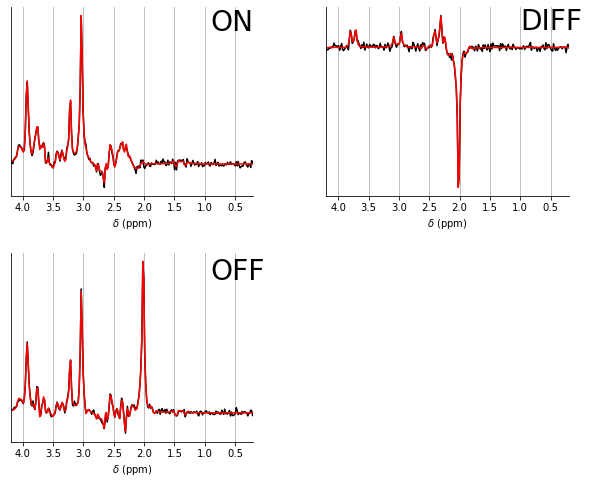

In [87]:
fig, axes = plt.subplots(2,2,figsize=(10, 8),)

def plot_spec_and_fit(ax, mrs,res):
    ax.plot(mrs.getAxes(),mrs.get_spec().real,'k')
    if res is not None:
        ax.plot(mrs.getAxes(ppmlim=[0.2,4.2]),res.predictedSpec(mrs).real,'r')
    ax.set_xlim([4.2,0.2])
    ax.set_xlabel('$\delta$ (ppm)')
    ax.set_yticks(ticks=[])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

plot_spec_and_fit(axes[0][0], plot_res['dyn']._dyn.mrs_list[1], plot_res['dyn'].reslist[1])
plot_spec_and_fit(axes[1][0], plot_res['dyn']._dyn.mrs_list[0], plot_res['dyn'].reslist[0])
plot_spec_and_fit(axes[0][1], plot_res['diff'][0], plot_res['diff'][1])

axes[1][0].text(0.9, 1000, 'OFF', fontsize=28)
axes[0][0].text(0.9, 850, 'ON', fontsize=28)
axes[0][1].text(1.0, 5, 'DIFF', fontsize=28)

axes[0][0].grid()
axes[1][0].grid()
axes[0][1].grid()

axes[1][1].axis('off')

plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.savefig('../publication/figure_creation/fig3_editing_explain_spectra.png', dpi=400, bbox_inches='tight')